### Foreground Sampling

In [1]:
import jax 
import nifty.re as jft 
import matplotlib.pyplot as plt 
import healpy as hp 
import jax.numpy as jnp 
from utils import load_config
from cmb import CMB
import camb

c = load_config()
cmb_model = CMB(c=c)

jax.config.update("jax_enable_x64", True)


Using config file: config.json


In [2]:
# Header for the free-free file 


print(hp.read_map('COM_CompMap_freefree-commander_0256_R2.00.fits', h = True)[1])

[('XTENSION', 'BINTABLE'), ('BITPIX', 8), ('NAXIS', 2), ('NAXIS1', 24), ('NAXIS2', 786432), ('PCOUNT', 0), ('GCOUNT', 1), ('TFIELDS', 6), ('COMMENT', ''), ('COMMENT', ' *** End of mandatory fields ***'), ('COMMENT', ''), ('EXTNAME', 'COMP-MAP-freefree'), ('EXTVER', 1), ('DATE', '2014-12-11'), ('COMMENT', ''), ('COMMENT', ' *** Column names ***'), ('COMMENT', ''), ('TTYPE1', 'EM_ML'), ('TTYPE2', 'EM_MEAN'), ('TTYPE3', 'EM_RMS'), ('TTYPE4', 'TEMP_ML'), ('TTYPE5', 'TEMP_MEAN'), ('TTYPE6', 'TEMP_RMS'), ('COMMENT', ''), ('COMMENT', ' *** Column formats ***'), ('COMMENT', ''), ('TFORM1', 'E'), ('TFORM2', 'E'), ('TFORM3', 'E'), ('TFORM4', 'E'), ('TFORM5', 'E'), ('TFORM6', 'E'), ('COMMENT', ''), ('COMMENT', '*** Column units ***'), ('COMMENT', ''), ('TUNIT1', 'cm^-6 pc'), ('TUNIT2', 'cm^-6 pc'), ('TUNIT3', 'cm^-6 pc'), ('TUNIT4', 'K'), ('TUNIT5', 'K'), ('TUNIT6', 'K'), ('COMMENT', ''), ('COMMENT', '*** Planck params ***'), ('COMMENT', ''), ('PIXTYPE', 'HEALPIX'), ('ORDERING', 'NESTED'), ('COOR

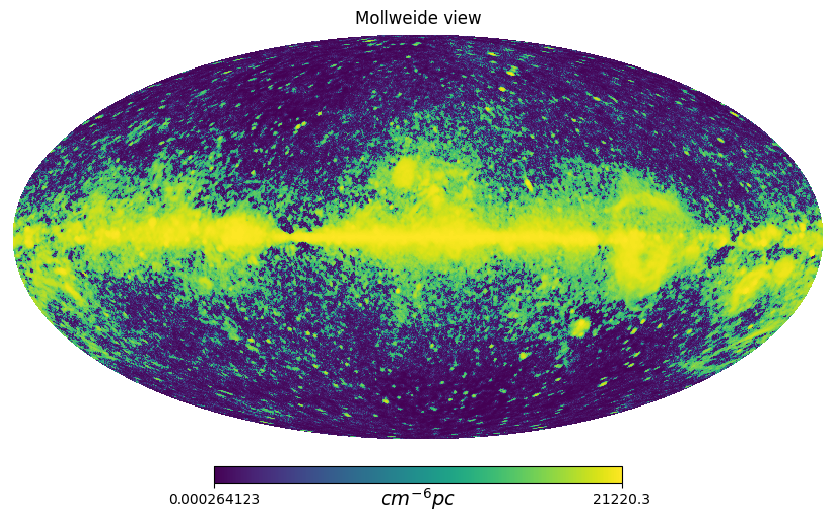

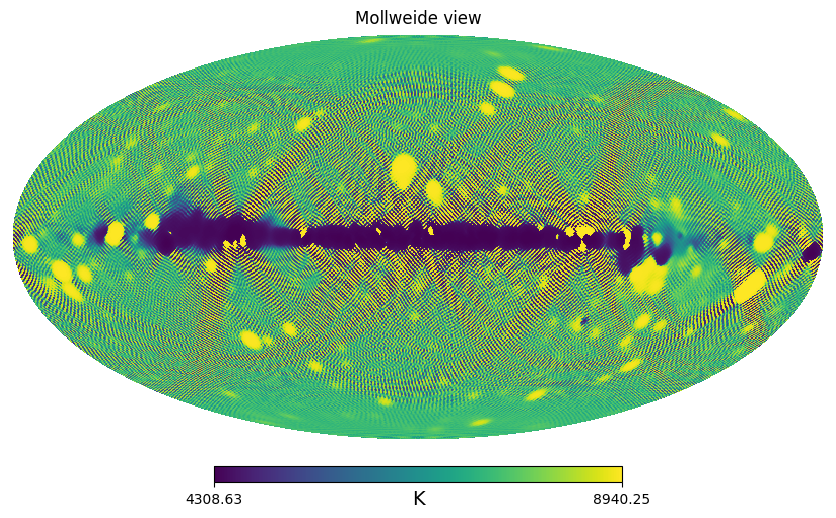

In [3]:
# EM and temperature as given by commander 

EM = jnp.asarray(hp.read_map('COM_CompMap_freefree-commander_0256_R2.00.fits', field= 1), dtype = jnp.float64)
hp.mollview(EM,  unit = '$cm^{-6}pc$', norm = 'hist')
tempy = jnp.asarray(hp.read_map('COM_CompMap_freefree-commander_0256_R2.00.fits', field= 4), dtype = jnp.float64)
hp.mollview(tempy, unit = 'K', norm = 'hist') # Why so ringed?

In [4]:
def freefree(EMff, temp, nus):
        # T_eff = 7000.0 # K
        nu_GHz = jnp.asarray(nus) * 1e-9
        g_ff = jnp.log(jnp.exp(5.960 - jnp.sqrt(3)/(jnp.pi * jnp.log(nu_GHz.reshape(nu_GHz.shape[0],1)* (1e-4 * temp.reshape(1,temp.shape[0]))**(-3/2)))) + jnp.e)
        tau = 0.05468 * (nu_GHz.reshape(nu_GHz.shape[0],1))**-2 * temp.reshape(1,temp.shape[0])**(-3/2) * g_ff * EMff
        free_free = temp * (-1 * jnp.expm1(-tau))
        return free_free


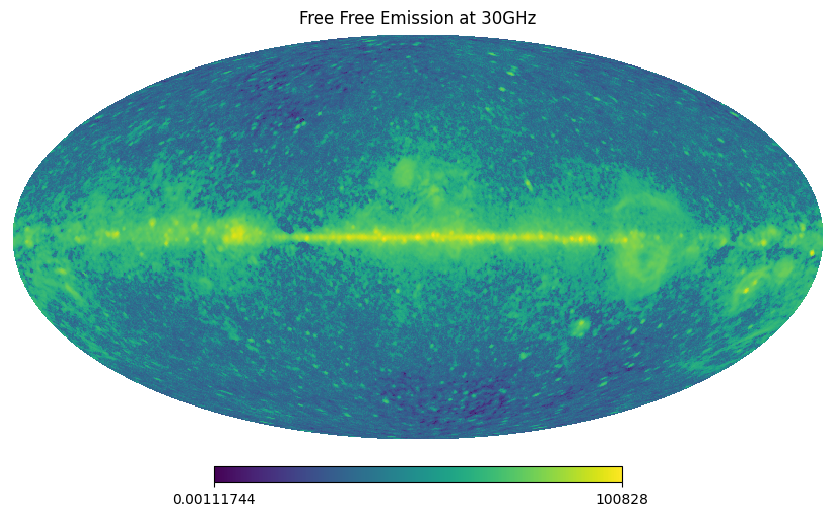

In [5]:
hp.mollview(freefree(EM, tempy, jnp.asarray(c['freqs']))[0]*1e6, norm = 'log', title = 'Free Free Emission at 30GHz')

In [6]:
from scipy.sparse.linalg import LinearOperator

# LinearOperator(dtype = jnp.float64, shape=[hp.Alm.getsize(2 * c['nside']) + 2, hp.Alm.getsize(2 * c['nside']) + 2])

In [7]:
import jaxbind.contrib.jaxducc0 as jaxducc0 
import numpy as np

f_temp = jax.random.normal(key = jax.random.PRNGKey(0), shape = (2, hp.nside2npix(c['nside'])))
fj = jax.random.normal(key = jax.random.PRNGKey(0), shape = (2, len(c['freqs'])))

f_temp = jnp.expand_dims(f_temp, axis = 1)
fj = jnp.expand_dims(fj, axis = 2)

Ninv = 1.

Nfjft = Ninv * fj * f_temp

ANf = jnp.sum(Nfjft, axis = 1) # [n_comp, n_pix]

sht = jaxducc0.get_healpix_sht(nside = c['nside'], lmax = 2 * c['nside'], mmax = 2 * c['nside'], spin = 0, nthreads=1) 

def adjoint_alm2map(x):
        x = jnp.expand_dims(x, axis = (1,2)) # Go from [n_comp, npix] to [n_comp,1,1,npix]
        alms = jnp.ones(hp.Alm.getsize(lmax = 2 * c['nside']), dtype = jnp.complex128)
        alms = alms.reshape((1, alms.shape[0]))
        sht_T = jax.linear_transpose(sht, jaxducc0._alm2realalm(alms, lmax = 2 * c['nside'], dtype = jnp.float64)) # alms proxy for shape, can have any value
        y = np.asarray([sht_T(list(x[i])) for i in range(2)]) # [n_comp, 1, 1, n_realalm]
        y = jnp.squeeze(y, axis = (1)) # [n_comp, 1, n_realalm]
        return jnp.squeeze(np.asarray([jaxducc0._realalm2alm(y[i], lmax = 2 * c['nside'], dtype = jnp.complex128) for i in range(2)]), axis = 1)


YTANf = adjoint_alm2map(ANf) # [2,n_alm]

YTANf.T.shape



(131841, 2)

In [8]:
import jaxbind.contrib.jaxducc0 as jaxducc0 
import numpy as np

class CG_template:
    def __init__(self, c, data, noise, C_ell, fj, f_temp):
        self.c = c 
        self.nside = self.c['nside']
        self.data = data 
        self.Ninv = noise**-1
        self.C_ell = C_ell 
        self.npix = hp.nside2npix(self.c['nside'])
        self.fj = fj 
        self.f_temp = f_temp

        self.res = 2 * hp.nside2resol(nside = self.c['nside']) #[rad]
        self.beam = hp.gauss_beam(fwhm = self.res, lmax = 2 * self.c['nside'])
        self.pwf = hp.pixwin(nside = self.c['nside'], lmax = 2 * self.c['nside'])
        self.Al = self.beam*self.pwf
        self.sht = jaxducc0.get_healpix_sht(nside = self.c['nside'], lmax = 2 * self.c['nside'], mmax = 2 * self.c['nside'], spin = 0, nthreads=1) 
    
    
    def apply_A(self, s, n_freq):
        s_beam = hp.almxfl(alm = s, fl = self.Al)
        s_beam = s_beam.reshape((1, s_beam.shape[0]))
        s_beam = jaxducc0._alm2realalm(s_beam, lmax = 2 * self.c['nside'], dtype = jnp.float64)
        spix_beam = self.sht(s_beam)
        return jnp.tile(spix_beam[0][0], n_freq)
    
    def adjoint_alm2map(x):
        x = jnp.expand_dims(x, axis = (1,2)) # Go from [2, npix] to [2,1,1,npix]
        alms = jnp.ones(hp.Alm.getsize(lmax = 2 * c['nside']), dtype = jnp.complex128)
        alms = alms.reshape((1, alms.shape[0]))
        sht_T = jax.linear_transpose(sht, jaxducc0._alm2realalm(alms, lmax = 2 * c['nside'], dtype = jnp.float64)) # alms proxy for shape, can have any value
        y = np.asarray([sht_T(list(x[i])) for i in range(2)]) #[2, 1, 1, n_realalm]
        y = jnp.squeeze(y, axis = (1)) # [2, 1, n_realalm]
        return jnp.squeeze(np.asarray([jaxducc0._realalm2alm(y[i], lmax = 2 * c['nside'], dtype = jnp.complex128) for i in range(2)]), axis = 1)
    
    def apply_A_transpose(self, stacked, n_freq):
        s_summed = stacked.reshape(n_freq, self.npix).sum(axis = 0)
        spix_summed = self.adjoint_alm2map(jnp.asarray(s_summed))
        s_beamed = hp.almxfl(alm = spix_summed[0], fl = self.Al)
        return s_beamed
    
    def apply_mat(self,x):
        '''Apply operator'''
        x = np.asarray(x)
        alm_cl = hp.almxfl(alm = x, fl = np.sqrt(self.C_ell)) # S^(1/2)x
        A_pix_alm = self.apply_A(alm_cl, self.c['nfreqs'])
        NA_pix = self.Ninv * A_pix_alm
        ATNA_pix = self.apply_A_transpose(NA_pix, self.c['nfreqs'])
        CATNA_alm = hp.almxfl(ATNA_pix, fl = np.sqrt(self.C_ell))


        return CATNA_alm + x



In [9]:
# Check the output of sht given (2, nalm) 
import jaxbind.contrib.jaxducc0 as jaxducc0 

sht = jaxducc0.get_healpix_sht(nside = c['nside'], lmax = 2 * c['nside'], mmax = 2 * c['nside'], spin = 0, nthreads=1) 

alm1 = hp.synalm(cls = jnp.ones(shape = (2 * c['nside'])), lmax = 2 * c['nside'])
alm1 = jaxducc0._alm2realalm(alm1.reshape(1,alm1.shape[0]), lmax = 2 * c['nside'], dtype = jnp.float64)
alm2 = hp.synalm(cls = jnp.ones(shape = (2 * c['nside'])), lmax = 2 * c['nside'])
alm2 = jaxducc0._alm2realalm(alm2.reshape(1,alm2.shape[0]), lmax = 2 * c['nside'], dtype = jnp.float64)

alms = jnp.stack(jnp.asarray([alm1, alm2]))

import numpy as np 

maps = np.asarray([sht(alms[i]) for i in range(2)])

maps = maps.reshape(2,-1) # [2, npix]


# (2,1,1,npix)
# Now define Y^T that the input is (2,npix)

def adjoint_alm2map(x):
        x = jnp.expand_dims(x, axis = (1,2)) # Go from [2, npix] to [2,1,1,npix]
        alms = jnp.ones(hp.Alm.getsize(lmax = 2 * c['nside']), dtype = jnp.complex128)
        alms = alms.reshape((1, alms.shape[0]))
        sht_T = jax.linear_transpose(sht, jaxducc0._alm2realalm(alms, lmax = 2 * c['nside'], dtype = jnp.float64)) # alms proxy for shape, can have any value
        y = np.asarray([sht_T(list(x[i])) for i in range(2)]) #[2, 1, 1, n_realalm]
        y = jnp.squeeze(y, axis = (1)) # [2, 1, n_realalm]
        return jnp.squeeze(np.asarray([jaxducc0._realalm2alm(y[i], lmax = 2 * c['nside'], dtype = jnp.complex128) for i in range(2)]), axis = 1)


YTmaps = adjoint_alm2map(maps) #[n_comp, n_alm]

In [10]:
EM.shape

(786432,)

In [11]:
freefree(EM, tempy, nus = c['freqs'])

Array([[5.09600104e-06, 3.24562260e-06, 1.51005502e-06, ...,
        1.49422371e-08, 6.25702461e-08, 1.48798679e-08],
       [2.37401719e-06, 1.51200201e-06, 7.03472495e-07, ...,
        6.96097334e-09, 2.91489028e-08, 6.93191811e-09]], dtype=float64)

[('XTENSION', 'BINTABLE'), ('BITPIX', 8), ('NAXIS', 2), ('NAXIS1', 12), ('NAXIS2', 786432), ('PCOUNT', 0), ('GCOUNT', 1), ('TFIELDS', 3), ('COMMENT', ''), ('COMMENT', ' *** End of mandatory fields ***'), ('COMMENT', ''), ('EXTNAME', 'COMP-MAP-Synchrotron'), ('EXTVER', 1), ('DATE', '2014-12-11'), ('COMMENT', ''), ('COMMENT', ' *** Column names ***'), ('COMMENT', ''), ('TTYPE1', 'I_ML'), ('TTYPE2', 'I_MEAN'), ('TTYPE3', 'I_RMS'), ('COMMENT', ''), ('COMMENT', ' *** Column formats ***'), ('COMMENT', ''), ('TFORM1', 'E'), ('TFORM2', 'E'), ('TFORM3', 'E'), ('COMMENT', ''), ('COMMENT', '*** Column units ***'), ('COMMENT', ''), ('TUNIT1', 'uK_RJ'), ('TUNIT2', 'uK_RJ'), ('TUNIT3', 'uK_RJ'), ('COMMENT', ''), ('COMMENT', '*** Planck params ***'), ('COMMENT', ''), ('PIXTYPE', 'HEALPIX'), ('ORDERING', 'NESTED'), ('COORDSYS', 'GALACTIC'), ('POLCCONV', 'COSMO'), ('POLAR', 'False'), ('NSIDE', 256), ('FIRSTPIX', 0), ('LASTPIX', 786431), ('INDXSCHM', 'IMPLICIT'), ('BAD_DATA', -1.6375e+30), ('METHOD', 'C

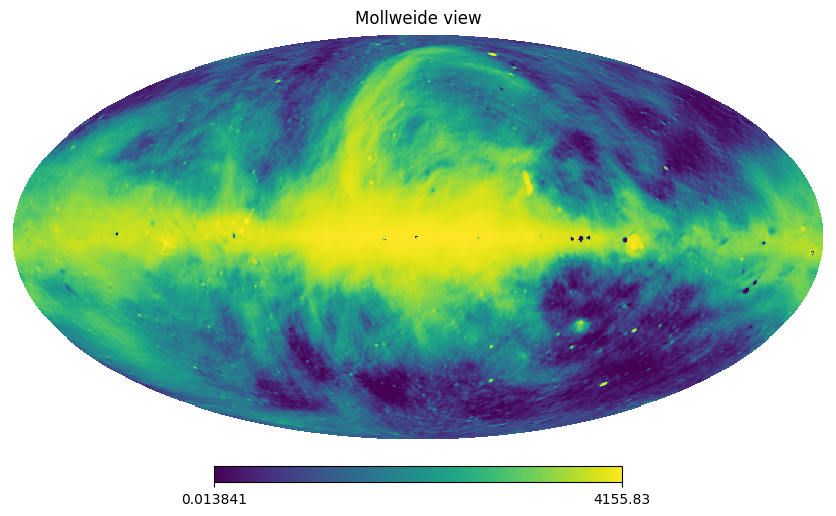

In [12]:
# Synchrotron 

# Read Data 

synch_data = hp.read_map('COM_CompMap_Synchrotron-commander_0256_R2.00.fits', h = True)

print(synch_data[1])

synch_em  = hp.read_map('COM_CompMap_Synchrotron-commander_0256_R2.00.fits', field = 1, )/1e6

hp.mollview(synch_em, norm = 'hist')

In [13]:
import astropy.io.fits as fits 

hdul = fits.open('COM_CompMap_Synchrotron-commander_0256_R2.00.fits')

nu_ref = dict(hdul[1].header)['NU_REF']

nus = [np.asarray(hdul[2].data[i])[0]*1e9 for i in range(78)]  # [Hz]
nus = [int(i) for i in nus]
i = [np.asarray(hdul[2].data)[i][1] for i in range(78)]

[float(nu_ref.split(' ')[0]) * 1e6 if nu_ref.split(' ')[1]=='MHz' else float(nu_ref.split(' ')[0]) * 1e9]

[408000000.0]

In [14]:
file = 'COM_CompMap_Synchrotron-commander_0256_R2.00.fits'
synch_map  = hp.read_map(file ,h = True, field = 1) #[K_RJ]
nu_ref = dict(synch_map[1])['NU_REF'].split(' ')

nu_ref = float(nu_ref[0]) * 1e6 if nu_ref[1]=='MHz' else float(nu_ref[0]) * 1e9



Text(0, 0.5, 'I $[W/Hz/m^2/sr]$')

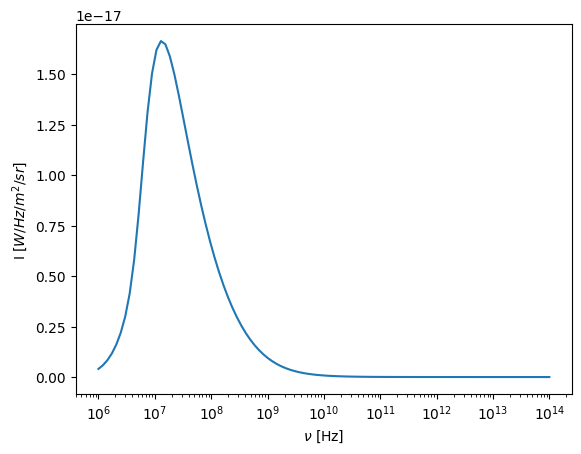

In [15]:
plt.plot(nus, i)
plt.xscale('log')
plt.xlabel('$ \\nu $ [Hz]')
plt.ylabel('I $[W/Hz/m^2/sr]$')

In [16]:
from scipy import interpolate

twerp = interpolate.interp1d(nus, i) 

twerp(np.asarray(c['freqs'])/0.26)/twerp(408e6/0.26)

array([0.00862399, 0.00572112])

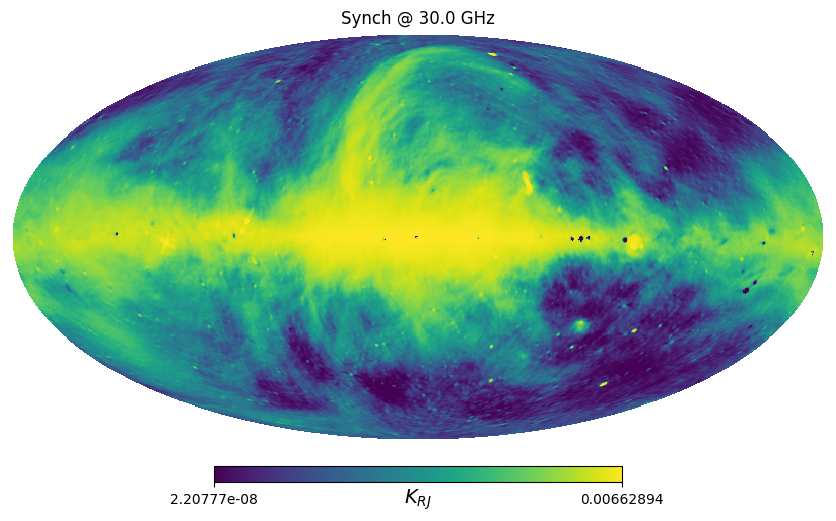

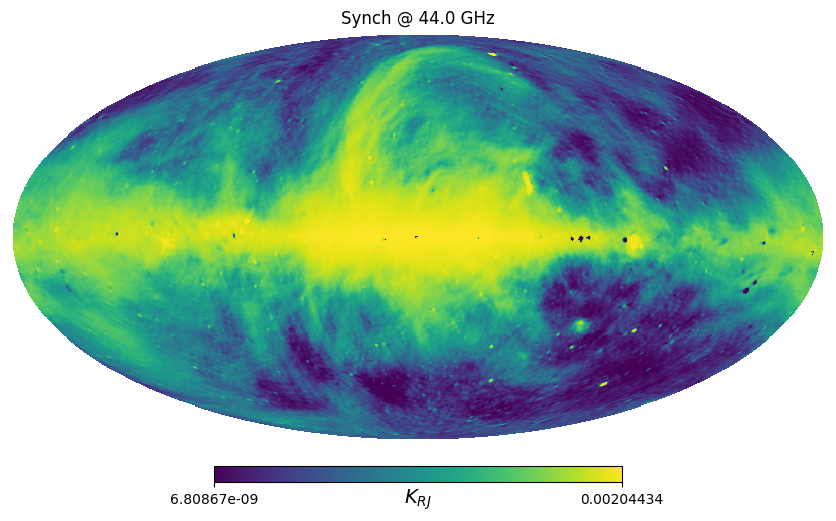

In [17]:
def synch_comm(A, freqs, nu_ref, alpha):
    hdul = fits.open('COM_CompMap_Synchrotron-commander_0256_R2.00.fits')
    nus = [np.asarray(hdul[2].data[i])[0]*1e9 for i in range(78)]  # [Hz]
    nus = [int(i) for i in nus]
    i = [np.asarray(hdul[2].data)[i][1] for i in range(78)]
    twerp = interpolate.interp1d(nus, i) 
    twerp(np.asarray(freqs)/0.26)/twerp(408e6/0.26)

    s = A.reshape(1, A.shape[0]) * ((nu_ref/freqs)**2).reshape(freqs.shape[0],1) * (twerp(np.asarray(freqs/alpha))/twerp(nu_ref/alpha)).reshape(freqs.shape[0],1)

    return s 


synch_signal = synch_comm(synch_em, np.asarray(c['freqs']), nu_ref=408e6, alpha = 0.26)

hp.mollview(synch_signal[0], norm = 'hist', title = f'Synch @ {c['freqs'][0]/1e9} GHz', unit = '$K_{RJ}$')

hp.mollview(synch_signal[1], norm = 'hist',  title = f'Synch @ {c['freqs'][1]/1e9} GHz',  unit = '$ K_{RJ}$')
    

In [18]:
# Now combining free-free and synch 


ff_signal = jnp.expand_dims(freefree(np.asarray(EM), tempy,  np.asarray(c['freqs'])), axis = 0)

synch_signal = jnp.expand_dims(synch_comm(synch_em, np.asarray(c['freqs']), nu_ref=408e6, alpha = 0.26), axis = 0)

signals = jnp.vstack([ff_signal, synch_signal])

In [ ]:
a = signals.T
b = Ninv * signals

FNF = jnp.einsum('ijk, lji-> kl', a, b)

In [ ]:
# Another einsum try: Pg 55 of notebook

nfreq = 7
npix = 1000
ncomp = 2

a = jax.random.normal(key = jax.random.PRNGKey(0), shape = (nfreq, npix))

b = jax.random.normal(key = jax.random.PRNGKey(0), shape = (ncomp, npix, nfreq))

jnp.einsum('ijk,kj->i', b,a)

# Works!



Array([ -4.25413049, -14.1395259 ], dtype=float64)

Sidequest: Get linear/log ticks on colorbar on mollview plots.

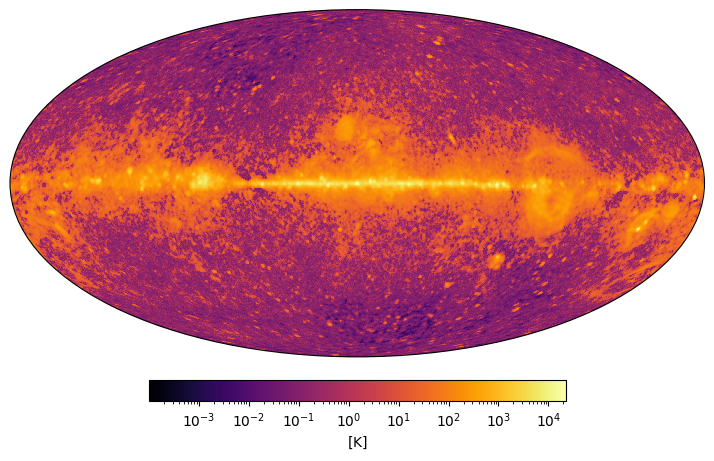

In [51]:
xsize = 2000
ysize = int(xsize/2)
nside = 256
theta = np.linspace(np.pi, 0, ysize)
phi   = np.linspace(-np.pi, np.pi, xsize)
longitude = np.radians(np.linspace(-180, 180, xsize))
latitude = np.radians(np.linspace(-90, 90, ysize))
m = hp.read_map('COM_CompMap_freefree-commander_0256_R2.00.fits', field = 1)
unit = r"$\mathrm{[K]}$"

PHI, THETA = np.meshgrid(phi, theta)
grid_pix = hp.ang2pix(nside, THETA, PHI)

grid_map = m[grid_pix]

# vmin = -1e2; vmax = 1e2

def cm2inch(value):
    return value/2.54

from matplotlib.projections.geo import GeoAxes

class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
    """Shifts labelling by pi

    Shifts labelling from -180,180 to 0-360"""
    def __call__(self, x, pos=None):
        if x != 0:
            x *= -1
        if x < 0:
            x += 2*np.pi
        return GeoAxes.ThetaFormatter.__call__(self, x, pos)
    
for width in [18.]:

    fig = plt.figure(figsize=(cm2inch(width), cm2inch(width)/(3./2.)))
    # matplotlib is doing the mollveide projection
    ax = fig.add_subplot(111,projection='mollweide')

    import matplotlib.colors as colors
    # rasterized makes the map bitmap while the labels remain vectorial
    # flip longitude to the astro convention
    image = plt.pcolormesh(longitude[::-1], latitude, grid_map, rasterized=True, cmap='inferno', norm=colors.LogNorm() ) # remove norm if i want linear cmap
    vmin = image.get_clim()[0]
    vmax = image.get_clim()[1]

    # graticule
    ax.set_longitude_grid(60)
    ax.xaxis.set_major_formatter(ThetaFormatterShiftPi(60))
    if width < 10:
        ax.set_latitude_grid(45)
        ax.set_longitude_grid_ends(90)
    import matplotlib.ticker as mticker
    # colorbar
    cb.locator = mticker.LogLocator(base=10)
    # cb.locator = mticker.MaxNLocator(nbins=7)   # linear ticks, nice values
    cb.formatter = mticker.LogFormatterSciNotation()
    cb.update_ticks()
    cb = fig.colorbar(image, orientation='horizontal', shrink=.6, pad=0.05)
    cb.set_label(unit, labelpad=4) 
    # workaround for issue with viewers, see colorbar docstring
    cb.solids.set_edgecolor("face")

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # remove tick labels
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    # remove grid
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    # remove white space around figure
    spacing = 0.01
    plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)

    plt.grid(True)